In [15]:
# The first model gives the conductance model as we discussed
# The second model is an simplified one using constant g
# The third model is the simple GRU model, should be the strongest one

'Data Preprocessing'
import torch
import math
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# get index of currently selected device
print(torch.cuda.current_device()) # returns 0 in my case

# get number of GPUs available
print(torch.cuda.device_count()) # returns 1 in my case

# get the name of the device
print(torch.cuda.get_device_name(0)) # good old Tesla K80

def snake_scan(img):
    'Converts a 32x32 image to a 32x96 array with snake-like row ordering'
    if len(img.shape) != 3:
        raise ValueError('Input image must be a 3D array')
    
    channels, rows, cols = img.shape
    snake = np.zeros((rows, cols * channels), dtype=img.dtype)
    for r in range(rows):
        row_data = img[:, r, :].flatten()  # Flattening each row into a 1D array of 96 elements
        if r % 2 == 1:
            row_data = row_data[::-1]  # Reversing the order for alternate rows
        snake[r] = row_data
    return snake

def stride(input_data, stride):
    'turn [batch_size, sequence_length, input_size] into [batch_size, sequence_length*input_size/stride, input_size]'
    batch_size, sequence_length, input_size = input_data.shape
    # flatten the input data to put sequence and input size together
    input_data = input_data.reshape(batch_size, -1)
    # append zeros to make sure the last pixel can be fed as the first pixel of the next sequence
    n = input_size - (sequence_length*input_size)%stride

    input_data = input_data.cpu()
    input_data = input_data.numpy()
    input_data = np.append(input_data, np.zeros((batch_size, n)), axis=1)
    input_data = torch.tensor(input_data)
    #print(input_data.shape)
    output_data = torch.zeros(batch_size, sequence_length*input_size//stride, input_size)
    for i in range(sequence_length*input_size//stride):
        # if stride = input size, then the output data is the same as input data
        #print(i)

        output_data[:,i,:] = input_data[:,i*stride:i*stride+input_size]
        #print(output_data[batch,i,:])

    return output_data

from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.transforms import Lambda

transform = transforms.Compose([
    ToTensor(),
    Lambda(lambda x: torch.tensor(snake_scan(x.numpy())))
])

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    download = True,
    transform = transform     
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    download = True,
    transform = transform
)




'Hyperparameters'
from torch import nn
import torch.nn.functional as F

input_size = 8
sequence_length = 28*28//input_size
hidden_size = 24
num_layers = 1
num_classes = 10
batch_size = 40
num_epochs = 5
learning_rate = 0.01
stride_number = 4

from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=0),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size, 
                                          shuffle=False, 
                                          num_workers=0),
}
loaders
'''
for i, (images, labels) in enumerate(loaders['train']):
    images = images.reshape(-1, sequence_length, input_size).to(device)
    images = stride(images, stride_number).to(device)
    print(images.shape)
    print(labels.shape)
    print(len(loaders['train']))
    break
'''

'Model Definition'

class Dale_CB_STPcell(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Dale_CB_STPcell, self).__init__()
        self.hidden_size = hidden_size
    
        ### Parameters ###
        # voltage gate v_t 
        self.P = torch.nn.Parameter(torch.empty(self.hidden_size, input_size))           
        self.b_v = torch.nn.Parameter(torch.zeros(self.hidden_size, 1))   

        # Update gate z_t
        # K and W are unbounded free parameters   
        # C represents  current based portion of connectivity       
        while True:
            self.K = torch.nn.Parameter(self.init_dale(self.hidden_size, self.hidden_size))
            self.C = torch.nn.Parameter(self.init_dale(self.hidden_size, self.hidden_size))
            nse_K = self.NSE(self.K)
            nse_C = self.NSE(self.C)
            if nse_K > 0.87 and nse_C > 0.87:
                break
        self.P_z = torch.nn.Parameter(torch.empty(self.hidden_size, input_size))
        self.b_z = torch.nn.Parameter(torch.empty(self.hidden_size, 1))   
        # Potentials are initialised with right signs
        self.e_e = torch.nn.Parameter(torch.rand(1))
        self.e_i = torch.nn.Parameter(-torch.rand(1))

        # Firing rate, Scaling factor and time step initialization
        self.v_t = torch.zeros(1, self.hidden_size, dtype=torch.float32)

        # dt is a constant
        self.dt = nn.Parameter(torch.tensor(1.0), requires_grad = False)
        self.z_high = nn.Parameter(torch.repeat_interleave(torch.tensor(0.2), self.hidden_size).reshape(self.hidden_size,1), requires_grad = False)
        self.z_low = torch.nn.Parameter(torch.zeros(self.hidden_size, 1, dtype=torch.float32), requires_grad = False)
        self.z_low[self.hidden_size//2:,:] = 0.1

        ### Nonlinear functions ###
        self.sigmoid = nn.Sigmoid()
        self.softplus = nn.Softplus()
        self.relu = nn.ReLU()

        ### Initialisation ###
        glorot_init = lambda w: nn.init.uniform_(w, a=-(1/math.sqrt(hidden_size)), b=(1/math.sqrt(hidden_size)))
        positive_glorot_init = lambda w: nn.init.uniform_(w, a=0, b=(1/math.sqrt(hidden_size)))

        # initialise matrices
        # P and P_z are unconstrained
        for w in self.P_z, self.P:
            glorot_init(w)
        for w in self.K, self.C:
            positive_glorot_init(w)
        # init b_z to be log 1/99
        nn.init.constant_(self.b_z, torch.log(torch.tensor(1/99)))

        ### STP Model ###
        self.delta_t = 1
        self.z_min = 0.001
        self.z_max = 0.1

        # Short term Depression parameters  
        self.c_x = torch.nn.Parameter(torch.rand(self.hidden_size, 1))

        # Short term Facilitation parameters
        self.c_u = torch.nn.Parameter(torch.rand(self.hidden_size, 1))
        self.c_U = torch.nn.Parameter(torch.rand(self.hidden_size, 1))
        
        # State initialisations
        self.X = torch.ones(self.hidden_size, 1, dtype=torch.float32).to(device)
        self.U = torch.full((self.hidden_size, 1), 0.9, dtype=torch.float32).to(device)
        self.Ucap = 0.9 * self.sigmoid(self.c_U)
        self.Ucapclone = self.Ucap.clone().detach() 

    def init_dale(self, rows, cols):
        # Dale's law with equal excitatory and inhibitory neurons
        exci = torch.empty((rows, cols//2)).exponential_(1.0)
        inhi = -torch.empty((rows, cols//2)).exponential_(1.0)
        weights = torch.cat((exci, inhi), dim=1)
        weights = self.adjust_spectral(weights)
        return weights

    def adjust_spectral(self, weights, desired_radius=1.5):
        values= torch.linalg.svdvals(weights)
        radius = values.abs().max()
        return weights * (desired_radius / radius)
    
    def NSE(self, weights):
        values = torch.linalg.svdvals(weights)
        normalised_v = values/sum(values)
        H = -1/torch.log(torch.tensor(self.hidden_size)) * torch.sum(normalised_v * torch.log(normalised_v))
        print(H)
        return H

    @property
    def r_t(self):
        return self.sigmoid(self.v_t)

    def forward(self, x):        
        if self.v_t.dim() == 3:           
            self.v_t = self.v_t[0]
        self.v_t = torch.transpose(self.v_t, 0, 1)

        ### Constraints###
        K = self.softplus(self.K)
        C = self.softplus(self.C)
        # W is constructed using e*(K+C)
        W_E = self.e_e * (K[:, :self.hidden_size//2] + C[:, :self.hidden_size//2])
        W_I = self.e_i * (K[:, self.hidden_size//2:] + C[:, self.hidden_size//2:])
        # print to see which device the tensor is on
        # If sign of W do not obey Dale's law, then these terms to be 0
        W_E = self.relu(W_E)
        W_I = -self.relu(-W_I)
        W = torch.cat((W_E, W_I), 1)
        self.W = W

        ### STP model ###
        x = torch.transpose(x, 0, 1)
        
        # Short term Depression 
        self.z_x = self.z_min + (self.z_max - self.z_min) * self.sigmoid(self.c_x)
        self.X = self.z_x + torch.mul((1 - self.z_x), self.X) - self.delta_t * self.U * self.X * self.r_t

        # Short term Facilitation 
        self.z_u = self.z_min + (self.z_max - self.z_min) * self.sigmoid(self.c_u)    
        self.Ucap = 0.9 * self.sigmoid(self.c_U)
        self.U = self.Ucap * self.z_u + torch.mul((1 - self.z_u), self.U) + self.delta_t * self.Ucap * (1 - self.U) * self.r_t
        self.Ucapclone = self.Ucap.clone().detach()
        self.U = torch.clamp(self.U, min=self.Ucapclone.repeat(1, x.size(0)).to(device), max=torch.ones_like(self.Ucapclone.repeat(1, x.size(0)).to(device)))
        x = torch.transpose(x, 0, 1)


        ### Update Equations ###
        self.z_t = torch.zeros(self.hidden_size, 1)
        self.z_t = self.dt*self.z_low + self.dt * (self.z_high - self.z_low)*self.sigmoid(torch.matmul(K , self.r_t) + torch.matmul(self.P_z, x) + self.b_z)
        
        self.v_t = (1 - self.z_t) * self.v_t + self.dt * (torch.matmul(W, self.U*self.X*self.r_t) + torch.matmul(self.P, x) + self.b_v)
        self.v_t = torch.transpose(self.v_t, 0, 1)      
        excitatory = self.v_t[:, :self.hidden_size//2]
        self.excitatory = torch.cat((excitatory, torch.zeros_like(excitatory)), 1)    


class Dale_CB_STP_batch(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, batch_first=True):
        super(Dale_CB_STP_batch, self).__init__()
        self.rnncell = Dale_CB_STPcell(input_size, hidden_size, num_layers).to(device)
        self.batch_first = batch_first

    def forward(self, x):
        if self.batch_first == True:
            for n in range(x.size(1)):
                #print(x.shape)
                x_slice = torch.transpose(x[:,n,:], 0, 1)
                self.rnncell(x_slice)
        return self.rnncell.excitatory            
            
class Dale_CB_STP(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(Dale_CB_STP, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = Dale_CB_STP_batch(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, 10)
        pass

    def forward(self, x):
        # Set initial hidden and cell states 
        self.lstm.rnncell.X = torch.ones(self.hidden_size, x.size(0), dtype=torch.float32).to(device)
        self.lstm.rnncell.U = (self.lstm.rnncell.Ucapclone.repeat(1, x.size(0))).to(device)
        self.lstm.rnncell.v_t = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        # Passing in the input and hidden state into the model and  obtaining outputs
        out = self.lstm(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        #Reshaping the outputs such that it can be fit into the fully connected layer
        out = self.fc(out)
        return out.squeeze(-1)
        
        pass                                    
pass

model = Dale_CB_STP(input_size, hidden_size, num_layers, num_classes).to(device)
print(model)
loss_func = nn.CrossEntropyLoss()

'Trajactory Tracking and Training'
from torch import optim
model_optimizer = optim.Adam(model.parameters(), lr = learning_rate)   

from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit

def subset_loader(full_dataset, batch_size, subset_ratio=0.1):
    # Generate labels array to use in stratified split
    labels = []
    for _, label in full_dataset:
        labels.append(label)
    labels = np.array(labels)

    # Perform a stratified shuffle split
    sss = StratifiedShuffleSplit(n_splits=1, test_size=subset_ratio, random_state=0)
    for train_index, test_index in sss.split(np.zeros(len(labels)), labels):
        stratified_subset_indices = test_index

    # Create a Subset instance with the stratified subset indices
    stratified_subset = Subset(full_dataset, stratified_subset_indices)

    # Create DataLoader from the subset
    subset_loader = DataLoader(
        stratified_subset,
        batch_size=batch_size,
        shuffle=False  # No need to shuffle as we already have a random subset
    )

    return subset_loader
subtest = subset_loader(test_data, batch_size)

def evaluate_while_training(model, loaders):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in subtest:
            images = images.reshape(-1, sequence_length, input_size).to(device)
            images = stride(images, stride_number).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

def train(num_epochs, model, loaders, patience=2, min_delta=0.01):
    model.train()
    total_step = len(loaders['train'])
    train_acc = []
    best_acc = 0
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            images = images.reshape(-1, sequence_length, input_size).to(device)
            images = stride(images, stride_number).to(device)
            labels = labels.to(device)
            model.train()
            # Forward pass
            outputs = model(images)
            loss = loss_func(outputs, labels)

            # Backward and optimize
            model_optimizer.zero_grad()
            loss.backward()
            model_optimizer.step()
            
            if (i+1) % 750 == 0:
                accuracy = evaluate_while_training(model, loaders)
                train_acc.append(accuracy)
                print('Epoch [{}/{}], Step [{}/{}], Training Accuracy: {:.2f}' 
                      .format(epoch + 1, num_epochs, i + 1, total_step, accuracy))

                # Check for improvement
                if accuracy - best_acc > min_delta:
                    best_acc = accuracy
                    no_improve_epochs = 0
                else:
                    no_improve_epochs += 1

                if no_improve_epochs >= patience:
                    print("No improvement in validation accuracy for {} epochs. Stopping training.".format(patience))
                    return train_acc

    return train_acc

train_acc = train(num_epochs, model, loaders)

Using device: cuda
0
1
NVIDIA GeForce RTX 4070 Laptop GPU
tensor(0.8820, grad_fn=<MulBackward0>)
tensor(0.8776, grad_fn=<MulBackward0>)
Dale_CB_STP(
  (lstm): Dale_CB_STP_batch(
    (rnncell): Dale_CB_STPcell(
      (sigmoid): Sigmoid()
      (softplus): Softplus(beta=1, threshold=20)
      (relu): ReLU()
    )
  )
  (fc): Linear(in_features=24, out_features=10, bias=True)
)
Epoch [1/5], Step [750/1500], Training Accuracy: 43.80
Epoch [1/5], Step [1500/1500], Training Accuracy: 54.60
Epoch [2/5], Step [750/1500], Training Accuracy: 55.80
Epoch [2/5], Step [1500/1500], Training Accuracy: 60.60
Epoch [3/5], Step [750/1500], Training Accuracy: 58.00
Epoch [3/5], Step [1500/1500], Training Accuracy: 66.00
Epoch [4/5], Step [750/1500], Training Accuracy: 66.10
Epoch [4/5], Step [1500/1500], Training Accuracy: 66.50
Epoch [5/5], Step [750/1500], Training Accuracy: 65.70


In [2]:
'Testing Accuracy'
# Test the model
model.eval()
X_history = []
U_history = []
v_t_history = []
z_t_history = []
labelslist = []

with torch.no_grad():
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in loaders['test']:
        model.lstm.rnncell.X_history = []
        model.lstm.rnncell.U_history = []
        model.lstm.rnncell.v_t_history = []
        model.lstm.rnncell.z_t_history = []
        images = images.reshape(-1, sequence_length, input_size).to(device)
        images = stride(images, stride_number).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted ==labels).sum().item()
        X_history.append(model.lstm.rnncell.X_history)
        U_history.append(model.lstm.rnncell.U_history)
        v_t_history.append(model.lstm.rnncell.v_t_history)
        z_t_history.append(model.lstm.rnncell.z_t_history)
        labelslist.append(labels)

test_acc = 100 * correct / total
print('Accuracy of the model:{}%'.format(test_acc))

# Retrieve weights
P = model.lstm.rnncell.P.detach().cpu().numpy()
W = model.lstm.rnncell.W.detach().cpu().numpy()
read_out = model.fc.weight.detach().cpu().numpy()


# Retrieve Ucap, z_u, z_x
Ucap = model.lstm.rnncell.Ucap
z_u = model.lstm.rnncell.z_u
z_x = model.lstm.rnncell.z_x
# save all the weights
torch.save({
    'P': P,
    'W': W,
    'read_out': read_out,
    'Ucap': Ucap,
    'z_u': z_u,
    'z_x': z_x,
}, 'weights.pt')



#Accuracy of the model:65.16%

Accuracy of the model:65.29%


[0.9818472  0.9586105  0.93356967 ... 0.282637   0.28536192 0.2891022 ]
[0.9818472  0.9586105  0.93356967 ... 0.27859032 0.28024557 0.2830819 ]
[0.9818472  0.9586105  0.93356967 ... 0.278342   0.2873555  0.2966076 ]
[0.9818472  0.9586105  0.93356967 ... 0.39659166 0.40730727 0.41808558]

In [3]:
# Convert a list of lists of tensors to a single numpy array
def convert_history(history_list):
    concatenated_history = []
    for batch in history_list:
        # Convert each tensor in the batch to numpy and append to a new list
        batch_history = [tensor.cpu().numpy() for tensor in batch]
        # Stack along a new dimension to keep batch data separate
        concatenated_history.append(np.stack(batch_history))
    # Concatenate all the batch data along the first dimension
    return np.concatenate(concatenated_history, axis=0)


def average_image(X_history, labelslist):

    neuronimage = []
    labelslist_array = convert_history(labelslist)
    order= np.argsort(labelslist_array.flatten())
    labelslist_array = labelslist_array.flatten()[order]
    # find number of 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
    _, counts = np.unique(labelslist_array, return_counts=True)
    X  = convert_history(X_history)
    X = X.reshape((250, 196, 24, 40))
    X = X.transpose(0, 3, 1, 2)
    X = X.reshape((10000, 196, 24))
    k=0
    for i in range(10):
        X_label = X[k:k+counts[i],:,:]
        X_label = X_label.mean(axis=0)
        neuronimage.append(X_label)
        k += counts[i]
    neuronimage = np.array(neuronimage)
    return neuronimage


In [4]:
%matplotlib ipympl

In [5]:
import matplotlib.pyplot as plt
# import colour
import matplotlib.colors as mcolors

X_nit = average_image(X_history, labelslist)
U_nit = average_image(U_history, labelslist)
v_nit = average_image(v_t_history, labelslist)
z_nit = average_image(z_t_history, labelslist)

torch.save({
    'X_nit': X_nit,
    'U_nit': U_nit,
    'v_nit': v_nit,
    'z_nit': z_nit,
}, 'neuronimage.pt')

In [ ]:
from matplotlib.widgets import Slider

import mpl_interactions.ipyplot as iplt


C:\Users\yawen cheng\AppData\Local\Temp\ipykernel_59468\1675873818.py:26: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, z, c=colors[class_index], label=f'Class {class_index}', alpha=0.4)


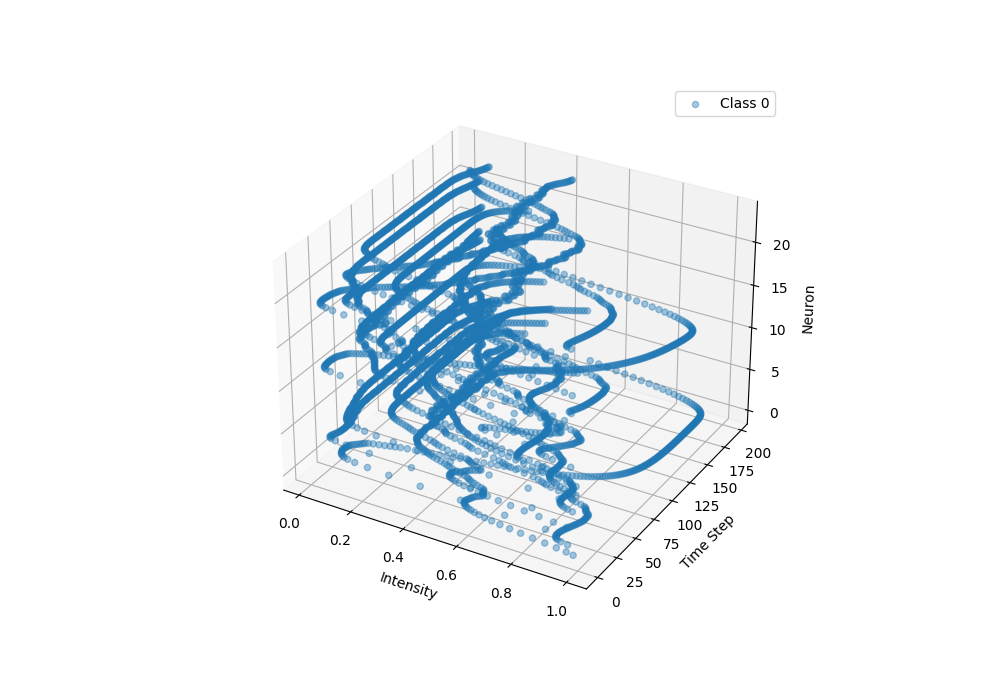

In [12]:
# Assuming X_nit has the shape (10, 196, 24) where
# - 10 represents different classes
# - 196 represents different time steps
# - 24 represents different neurons
# We want to plot all these points in a single 3D scatter plot with each class represented by a different color.
# First, let's set up the figure and 3D axis
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Create a color palette with 10 different colors, one for each class
colors = plt.cm.tab10(np.linspace(0, 1, 10))

# Loop over the classes
for class_index in range(1):
    # Extract the data for the current class
    class_data = X_nit[class_index]

    # Flatten the time step and neuron dimensions to get all points for the current class
    x = class_data.flatten()
    
    # Create arrays for y and z that correspond to the time step and neuron index, respectively
    y = np.repeat(np.arange(class_data.shape[0]), class_data.shape[1])
    z = np.tile(np.arange(class_data.shape[1]), class_data.shape[0])

    # Plot the points for the current class in their unique color
    ax.scatter(x, y, z, c=colors[class_index], label=f'Class {class_index}', alpha=0.4)

# Set the labels for the axes
ax.set_xlabel('Intensity')
ax.set_ylabel('Time Step')
ax.set_zlabel('Neuron')

# Add a legend to identify classes
ax.legend()

# Show the plot
plt.show()


(10, 196, 24)
(10, 196, 24)


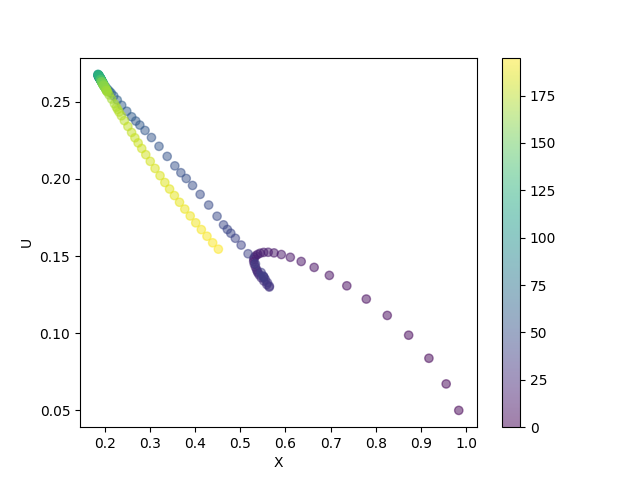

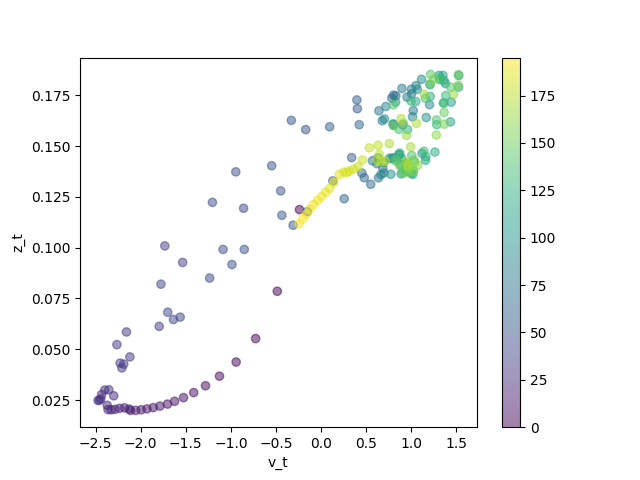

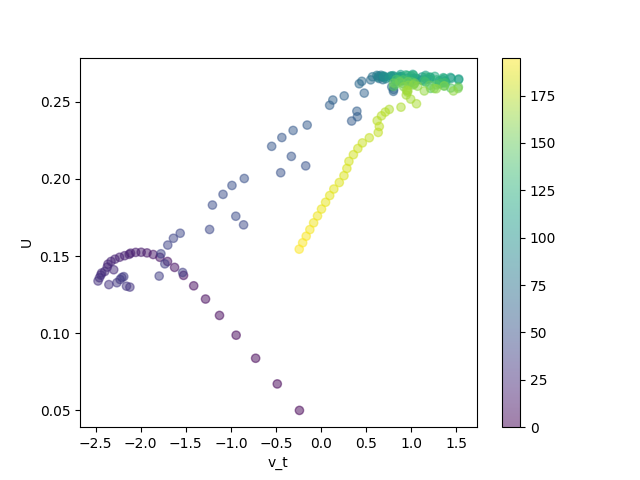

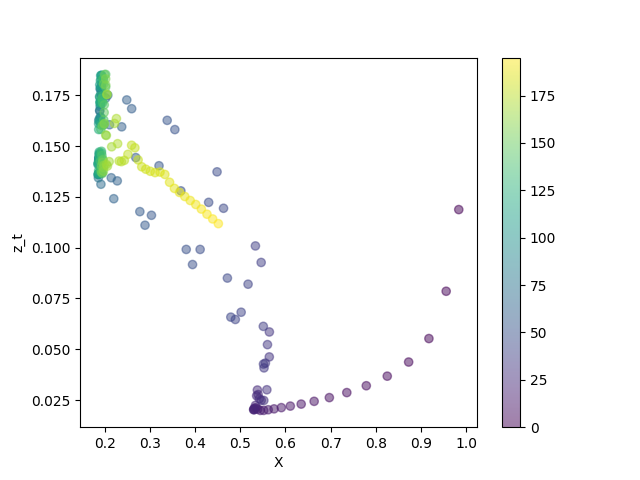

In [71]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
print(X_nit.shape)
print(U_nit.shape)
plt.figure()
plt.scatter(X_nit[0, :, 0], U_nit[0, :, 0], c=np.arange(196), cmap='viridis', alpha=0.5)
plt.colorbar()
plt.xlabel('X')
plt.ylabel('U')
plt.show()

plt.figure()
plt.scatter(v_nit[0, :, 0], z_nit[0, :, 0], c=range(196), cmap='viridis', alpha=0.5)
plt.colorbar()
plt.xlabel('v_t')
plt.ylabel('z_t')
plt.show()

plt.figure()
plt.scatter(v_nit[0, :, 0], U_nit[0, :, 0], c=range(196), cmap='viridis', alpha=0.5)
plt.colorbar()
plt.xlabel('v_t')
plt.ylabel('U')
plt.show()

plt.figure()
plt.scatter(X_nit[0, :, 0], z_nit[0, :, 0], c=range(196), cmap='viridis', alpha=0.5)
plt.colorbar()
plt.xlabel('X')
plt.ylabel('z_t')
plt.show()



(196, 24)


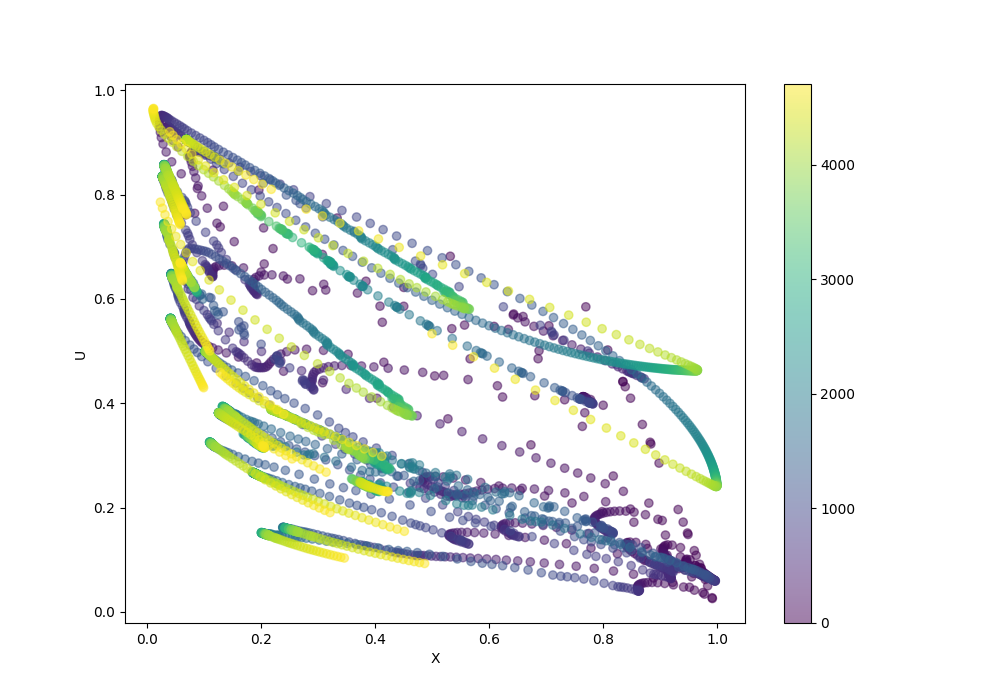

In [30]:
print(X_nit[0].shape)
#clear plot
plt.clf()
plt.scatter(X_nit[0].flatten(),  U_nit[0].flatten(), c= np.arange(196*24),cmap='viridis', alpha=0.5)
plt.colorbar()
plt.xlabel('X')
plt.ylabel('U')
plt.show()

In [57]:
%matplotlib qt


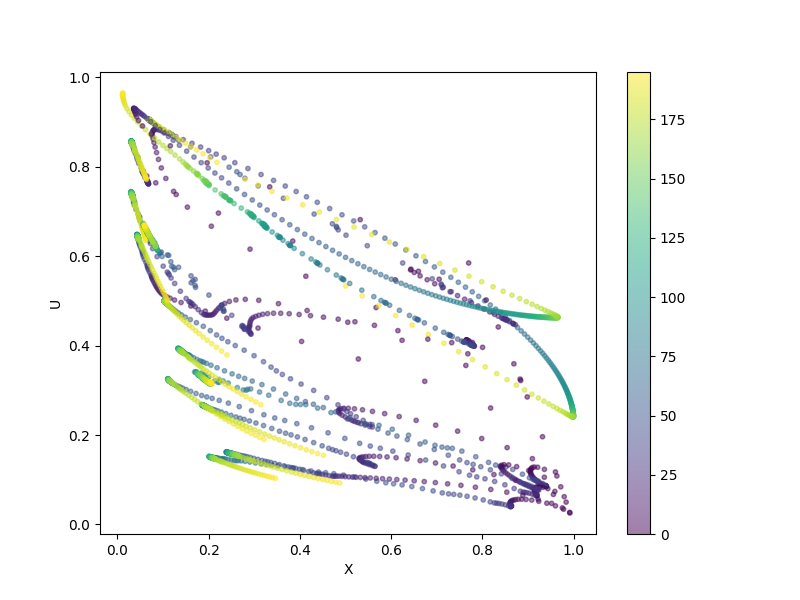

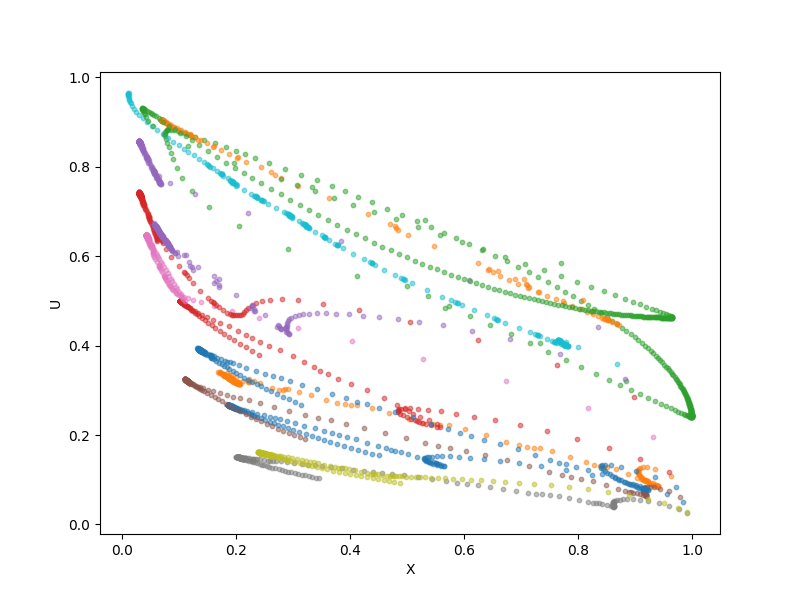

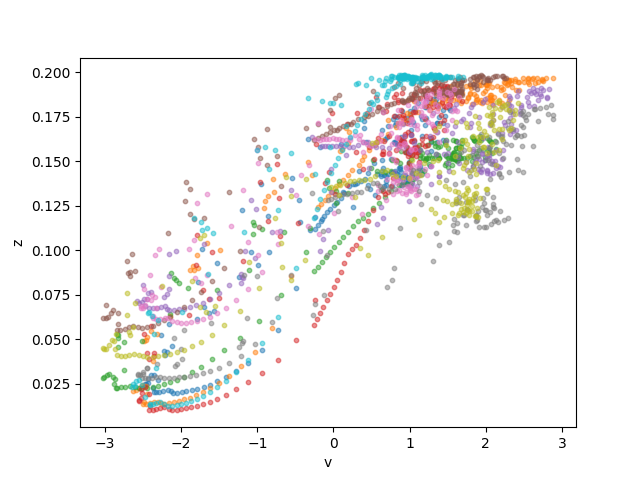

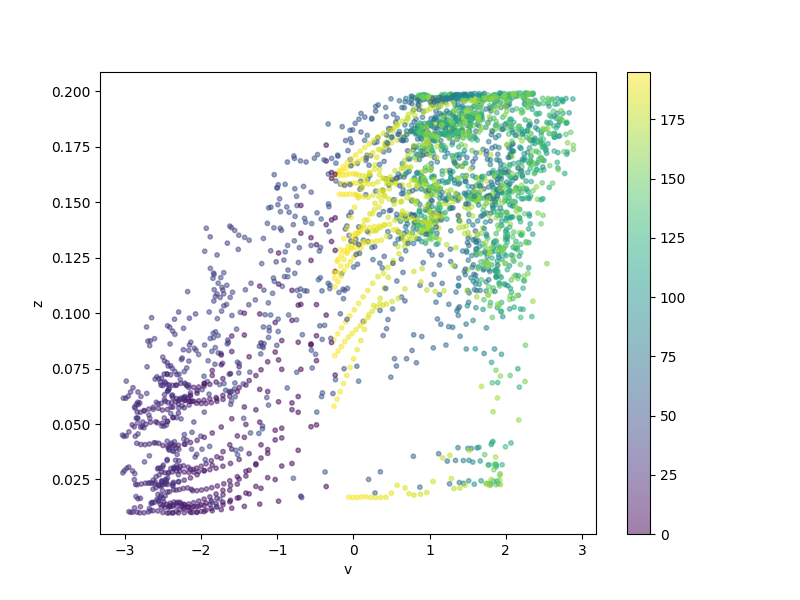

In [65]:

#clear plot
plt.figure(figsize=(8,6))
for i in range(15):
    plt.scatter(X_nit[0][:,i], U_nit[0][:,i],label = 'Neuron {}'.format(i), s = 10, alpha=0.5, c = np.arange(196), cmap = 'viridis')
plt.xlabel('X')
plt.ylabel('U')
plt.colorbar()
plt.show()

plt.figure(figsize=(8,6))
for i in range(15):
    plt.scatter(X_nit[0][:,i], U_nit[0][:,i],label = 'Neuron {}'.format(i), s = 10, alpha=0.5)
plt.xlabel('X')
plt.ylabel('U')
plt.show()

plt.figure()
for i in range(10):
    plt.scatter(v_nit[0][:,i], z_nit[0][:,i],label = 'Neuron {}'.format(i),s = 10, alpha=0.5)
plt.xlabel('v')
plt.ylabel('z')
plt.show()

plt.figure(figsize=(8,6))
for i in range(15):
    plt.scatter(v_nit[0][:,i], z_nit[0][:,i],label = 'Neuron {}'.format(i), s = 10, alpha=0.5, c = np.arange(196), cmap = 'viridis')
plt.xlabel('v')
plt.ylabel('z')
plt.colorbar()
plt.show()


In [ ]:

#clear plot
plt.figure(figsize=(8,6))
for i in range(15):
    plt.scatter(X_nit[0][:,i], U_nit[0][:,i],label = 'Neuron {}'.format(i), s = 10, alpha=0.5, c = np.arange(196), cmap = 'viridis')
plt.xlabel('X')
plt.ylabel('U')
plt.colorbar()
plt.show()

plt.figure(figsize=(8,6))
for i in range(15):
    plt.scatter(X_nit[0][:,i], U_nit[0][:,i],label = 'Neuron {}'.format(i), s = 10, alpha=0.5)
plt.xlabel('X')
plt.ylabel('U')
plt.show()

plt.figure()
for i in range(10):
    plt.scatter(v_nit[0][:,i], z_nit[0][:,i],label = 'Neuron {}'.format(i),s = 10, alpha=0.5)
plt.xlabel('v')
plt.ylabel('z')
plt.show()

plt.figure(figsize=(8,6))
for i in range(15):
    plt.scatter(v_nit[0][:,i], z_nit[0][:,i],label = 'Neuron {}'.format(i), s = 10, alpha=0.5, c = np.arange(196), cmap = 'viridis')
plt.xlabel('v')
plt.ylabel('z')
plt.colorbar()
plt.show()


(24, 3)
(24, 3)
(24, 3)
(24, 3)
(24, 3)
(24, 3)
(24, 3)
(24, 3)
(24, 3)
(24, 3)


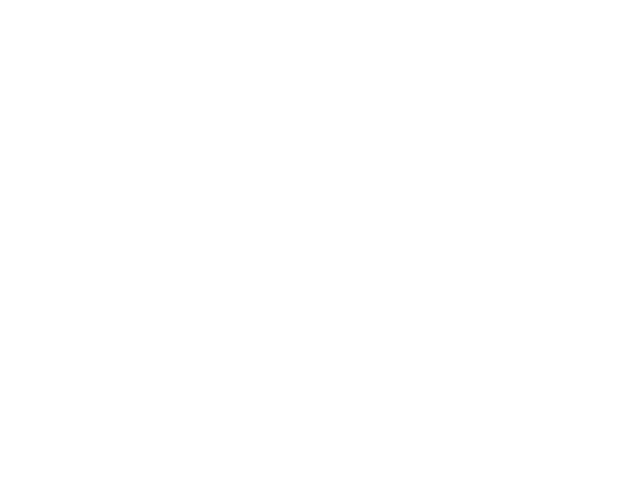

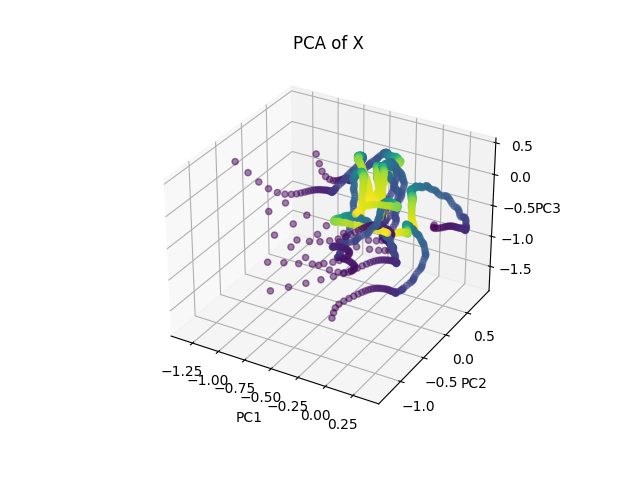

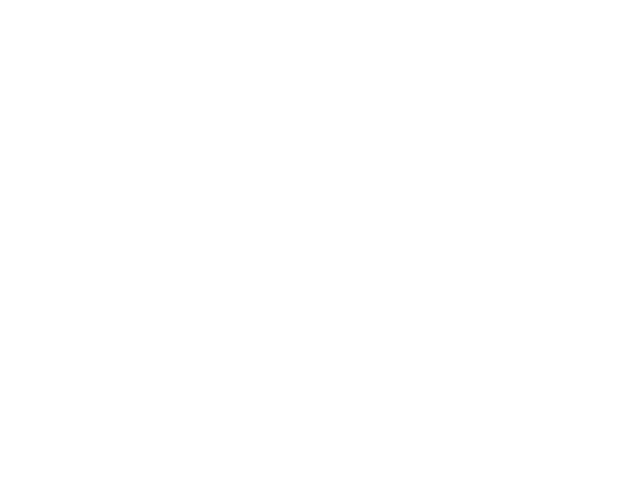

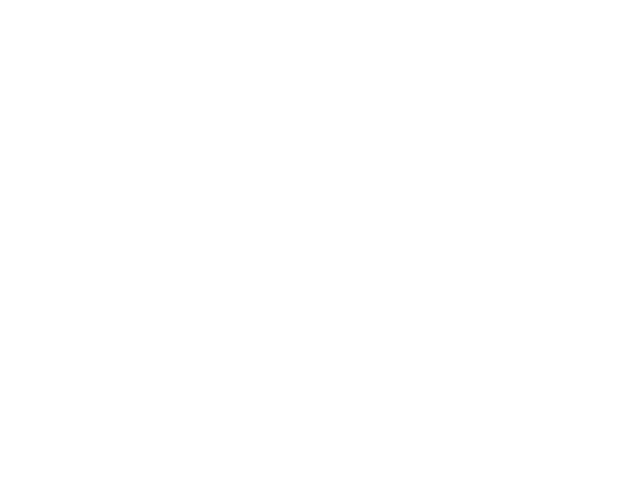

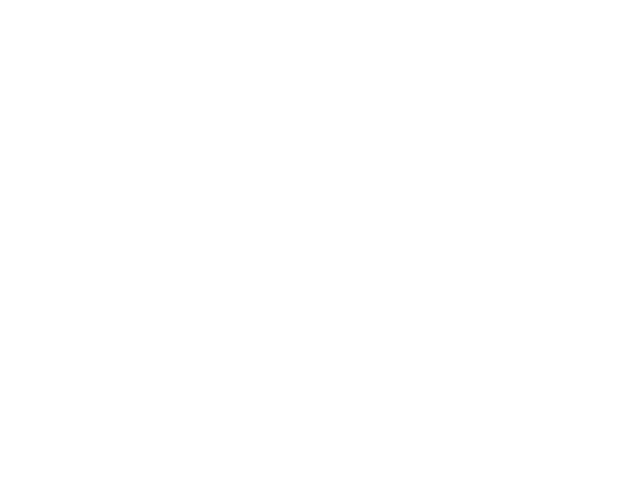

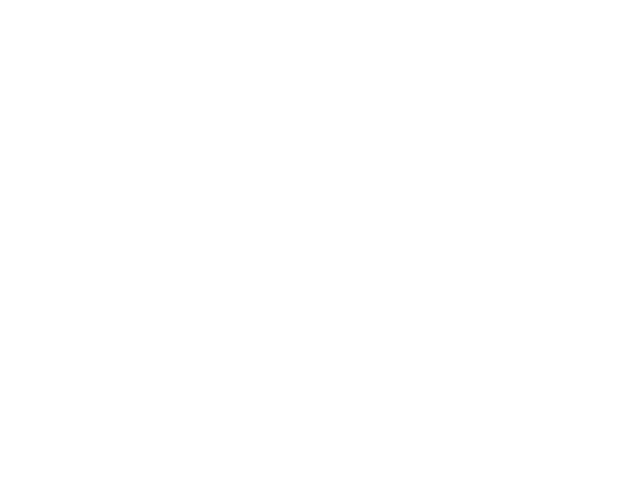

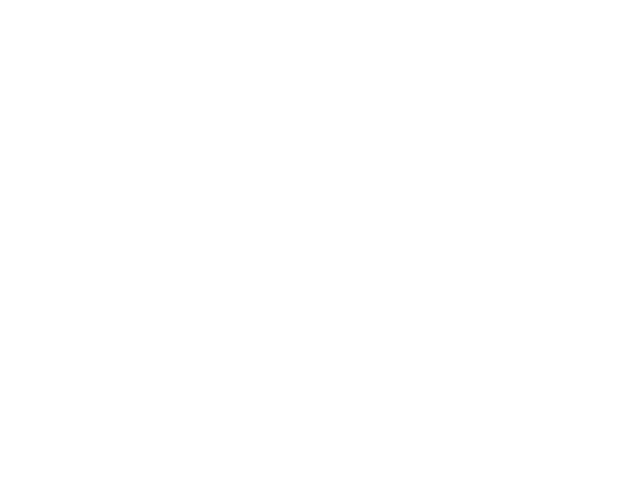

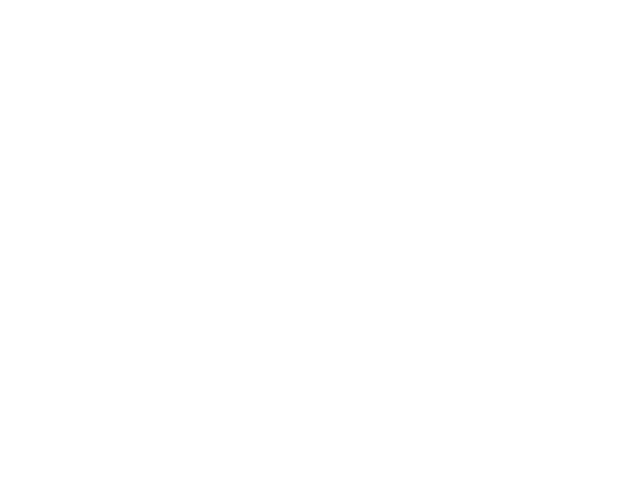

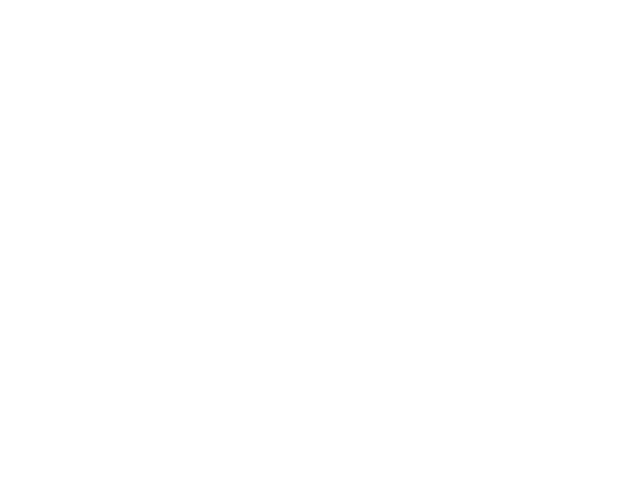

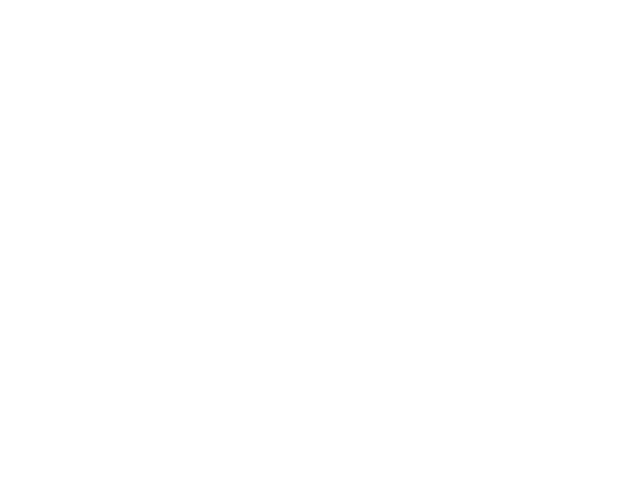

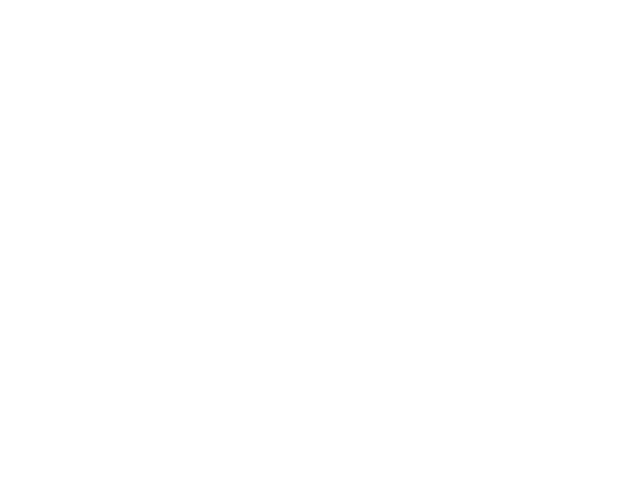

In [124]:

def pca(X_nit):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for i in range(10):
        u, s, v = np.linalg.svd(X_nit[i])
        P = v[:,:3]
        print(P.shape)
        Y = X_nit[i] @ P
        Y = Y.T
        plt.figure()
        # 3d scatter plot
        ax.scatter3D(Y[0,:], Y[1,:], Y[2,:], c=np.arange(196), cmap='viridis', alpha=0.5)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    # add string s to the title
    ax.set_title('PCA of X')
    plt.show()

pca(X_nit)